# 1、
Write down the mathematical requirement for this model to be arbitrage free.
You should include a check for this in your code

- d < 1+r <u

# 2、
Write a function that prices a European Call or Put option under the Binomial
Model. It should take in as arguments:

- optype: ‘C’ for Call option and ‘P’ for Put option.
- extype: ‘E’ for European and ‘A’ for American.
- S0: the initial value of the underlying asset.
- K: the option strike.
- σ: The annualized volatility of the asset.
- T: The time to expiry of the option.
- r: The continuously compounding interest rate.
- N: the number of time steps for the Binomial tree (thereby defining ∆t =T/N)

In [1]:
import numpy as np
import pandas as pd 

def get_option_price(optype,extype,S0,K,sigma,T,r,N):
    """_summary_

    Args:
        optype: ‘C’ for Call option and ‘P’ for Put option.
        extype: ‘E’ for European and ‘A’ for American.
        S0: the initial value of the underlying asset.
        K: the option strike.
        sigma: The annualized volatility of the asset.
        T: The time to expiry of the option.
        r: The continuously compounding interest rate.
        N: the number of time steps for the Binomial tree (thereby defining ∆t =T/N)
    """
# 主体函数 
    # 使用的通用数据 
    # 第一步：计算对应的u、d、p值 
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt)-d)/(u-d)
    # 判断条件
    if not 1+r<u and 1+r>d:
        raise ValueError("Don't satisfy the no-arbitrage condition.")
    
    # 欧式 
    if extype == "E":
        # 初始化矩阵 
        # 股票价格矩阵 
        S = np.zeros((N+1,N+1))
        # payoff矩阵 
        V= np.zeros((N+1,N+1))
        # 第二步：计算股票价格矩阵
        S[0,:] = [S0*u**j for j in range(N+1)]
        # 展示股票价格变化矩阵 
        for i in range(1,N+1):
            for j in range(i,N+1):
                    S[i,j] = S[i-1,j]*d/u

        if optype == "C":
            V[:,-1] = [max((S[i,N]-K),0) for i in range(N+1)]
        elif optype == "P":
            V[:,-1] = [max((K-S[i,N]),0) for i in range(N+1)]
        else:
            raise ValueError("optype should be 'C' or 'P'")
                # 从后向前计算payoff
        for j in range(N-1,-1,-1):
            for i in range(j+1):
                V[i,j] = p*V[i,(j+1)]+(1-p)*V[(i+1),(j+1)]
        # 返回折现后的V[0,0]作为option price
        option_price = V[0,0]*np.exp(-r * np.sqrt(T))
        return option_price

    # 美式
    elif extype == "A":
        # V承接N+1个价格
        V = np.zeros(N+1)
        # 注意S_T的生成顺序，是从u=0,d=N开始.                            
        S = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T
        if optype == "C":
            V[:] = np.maximum(S-K, 0.0)
            for i in range(N-1, -1, -1):
                # 这一步至关重要：V在第k轮迭代中，只关注0~N-k的位置，
                # 每个位置=（下一个位置上升的期权*p+下一个位置下降的期权*q）*折现因子
                V[:-1] = np.exp(-r*dt) * (p * V[1:] + (1-p) * V[:-1])    
                # 股价也进行新一轮的迭代，同样只有0~N-k是需要关注的，剩下的位置无关紧要。
                S = S * u       
                # 比较此刻行权和下一轮预期收益的折现
                V = np.maximum( V, S-K )
        elif optype == "P":
            V[:] = np.maximum(S-K, 0.0)
            for i in range(N-1, -1, -1):
                # 这一步至关重要：V在第k轮迭代中，只关注0~N-k的位置，
                # 每个位置=（下一个位置上升的期权*p+下一个位置下降的期权*q）*折现因子
                V[:-1] = np.exp(-r*dt) * (p * V[1:] + (1-p) * V[:-1])    
                # 股价也进行新一轮的迭代，同样只有0~N-k是需要关注的，剩下的位置无关紧要。
                S = S * u       
                # 比较此刻行权和下一轮预期收益的折现
                V = np.maximum( V, K-S )
        else:
            raise ValueError("optype should be 'C' or 'P'")

        return V[0]

In [2]:
# 测试函数
try:
    option_prince = get_option_price(optype='C',extype='E',S0=100,K=100,sigma=0.2,T=2,r=0.015,N=200)
    print(option_prince)
except ValueError as e:
    print("An exception occurred:", str(e))

12.71700988151952


# 3、
Check the convergence of the premium that your function returns as you increase the size N by plotting the price of a call option against the value of
N.


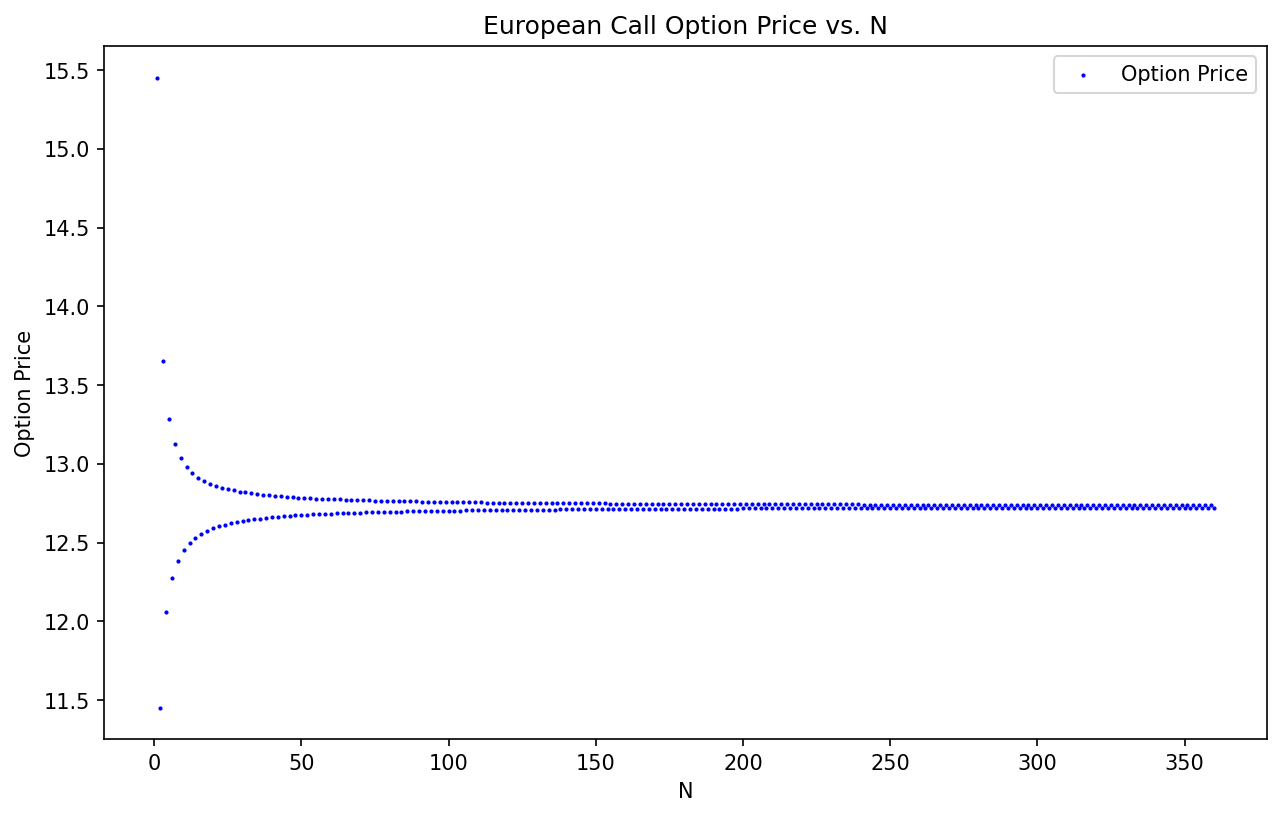

In [3]:
# 根据无套利约束条件，在N=200，r=0.015,sigma = 0.2的条件下，N<361，因此取N从1-360的值

# N从1-360的的取值 
N_list = [i for i in range(1,361)]
# 欧式call option的取值 
european_call_option_price_list = [get_option_price(optype='C',extype='E',S0=100,K=100,sigma=0.2,T=2,r=0.015,N=j)
                     for j in N_list]
# 绘图
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi = 150)
plt.scatter(N_list, european_call_option_price_list, label='Option Price', color='b',s = 1)
plt.xlabel('N')
plt.ylabel('Option Price')
plt.title('European Call Option Price vs. N')
plt.legend()
plt.show()

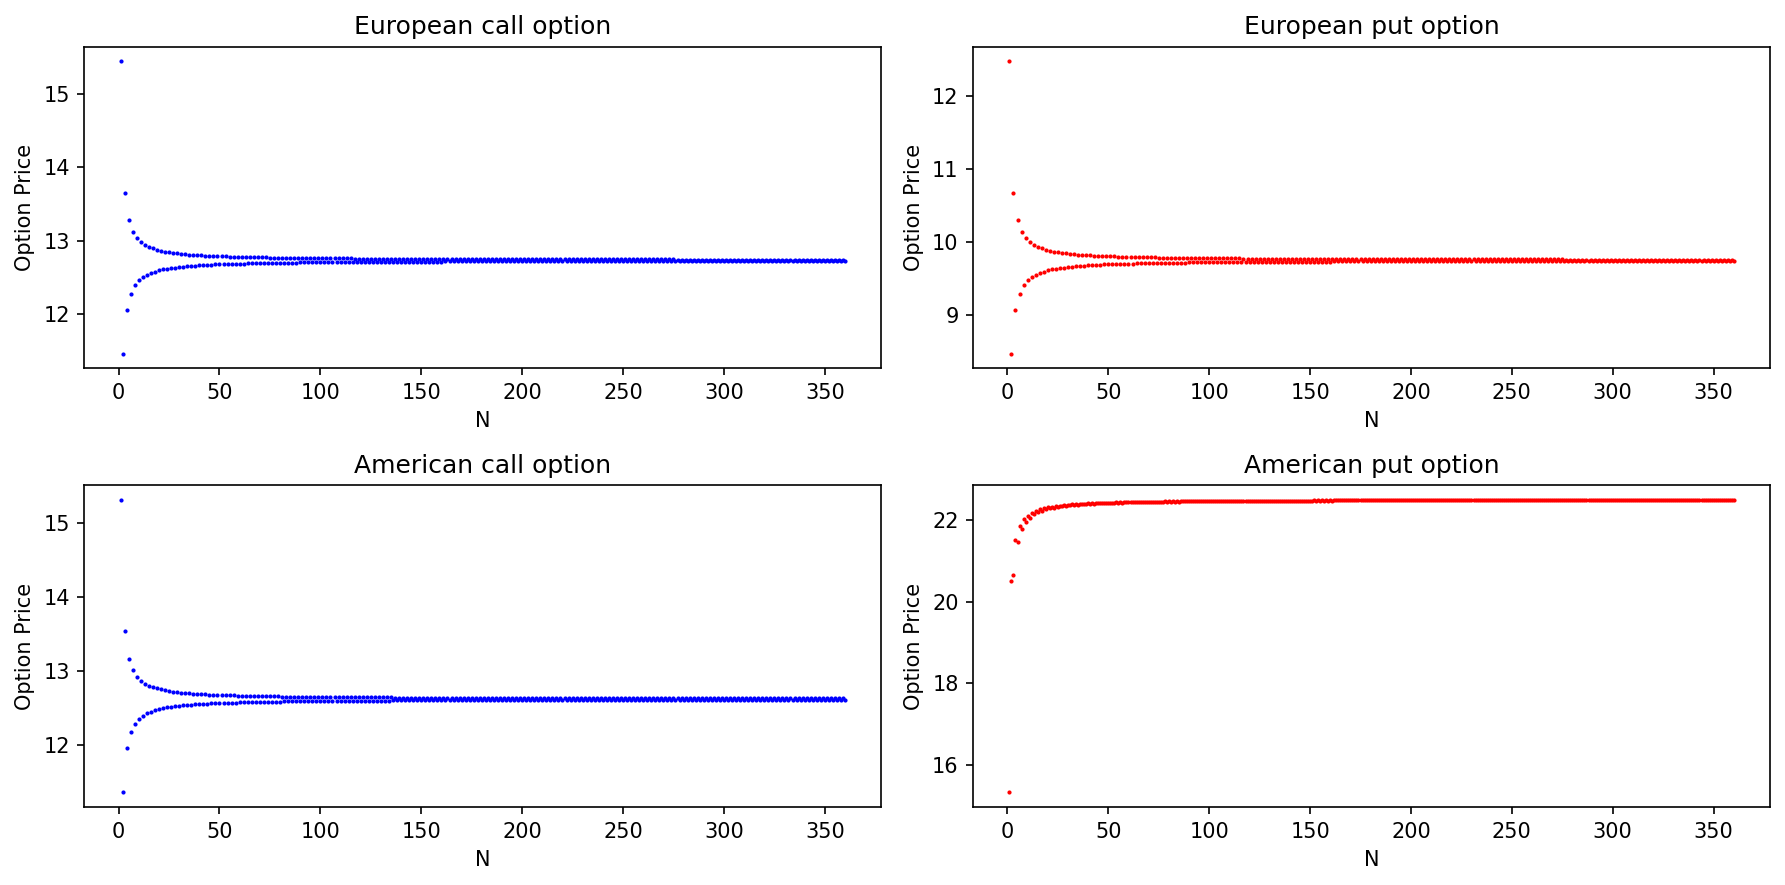

In [4]:
# 展示欧式call、欧式put、美式call、美式put期权价格随着N多变化的图 
# N从1-360
# N从1-360的的取值 
N_list = [i for i in range(1,361)]

european_call_price_list = [get_option_price(optype='C',extype='E',S0=100,K=100,sigma=0.2,T=2,r=0.015,N=j) for j in N_list]
european_put_price_list = [get_option_price(optype='P',extype='E',S0=100,K=100,sigma=0.2,T=2,r=0.015,N=j) for j in N_list]
american_call_price_list = [get_option_price(optype='C',extype='A',S0=100,K=100,sigma=0.2,T=2,r=0.015,N=j) for j in N_list]
american_put_price_list = [get_option_price(optype='P',extype='A',S0=100,K=100,sigma=0.2,T=2,r=0.015,N=j) for j in N_list]

# 绘图展示 
# 绘图
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6),dpi = 150)
# 创建4个子图
plt.subplot(2, 2, 1)
plt.scatter(N_list , european_call_price_list,label='Option Price', color='b',s = 1)
plt.title('European call option')
plt.xlabel('N')
plt.ylabel('Option Price')

plt.subplot(2, 2, 2)
plt.scatter(N_list , european_put_price_list,label='Option Price', color='r',s = 1)
plt.title('European put option')
plt.xlabel('N')
plt.ylabel('Option Price')

plt.subplot(2, 2, 3)
plt.scatter(N_list , american_call_price_list,label='Option Price', color='b',s = 1)
plt.title('American call option')
plt.xlabel('N')
plt.ylabel('Option Price')

plt.subplot(2, 2, 4)
plt.scatter(N_list , american_put_price_list,label='Option Price', color='r',s = 1)
plt.title('American put option')
plt.xlabel('N')
plt.ylabel('Option Price')

plt.tight_layout()  # 调整子图布局，避免重叠
plt.show()

# 5、
Compare prices of European versus American Calls and Puts for a few different
strikes: [90, 95, 100, 105, 110]. You should make an interesting observation with
regards to the Calls.


In [5]:
# 更改K的值，查看对应的option price的变化 
K_list = [90, 95, 100, 105, 110]

# 当K变化的时候，提取对应的期权价格 
K_european_call_option_price_list = [get_option_price(optype='C',extype='E',S0=100,K=j,sigma=0.2,T=2,r=0.015,N=200) for j in K_list]
K_european_put_option_price_list = [get_option_price(optype='P',extype='E',S0=100,K=j,sigma=0.2,T=2,r=0.015,N=200) for j in K_list]
K_american_call_option_price_list = [get_option_price(optype='C',extype='A',S0=100,K=j,sigma=0.2,T=2,r=0.015,N=200) for j in K_list]
K_american_put_option_price_list = [get_option_price(optype='P',extype='A',S0=100,K=j,sigma=0.2,T=2,r=0.015,N=200) for j in K_list]


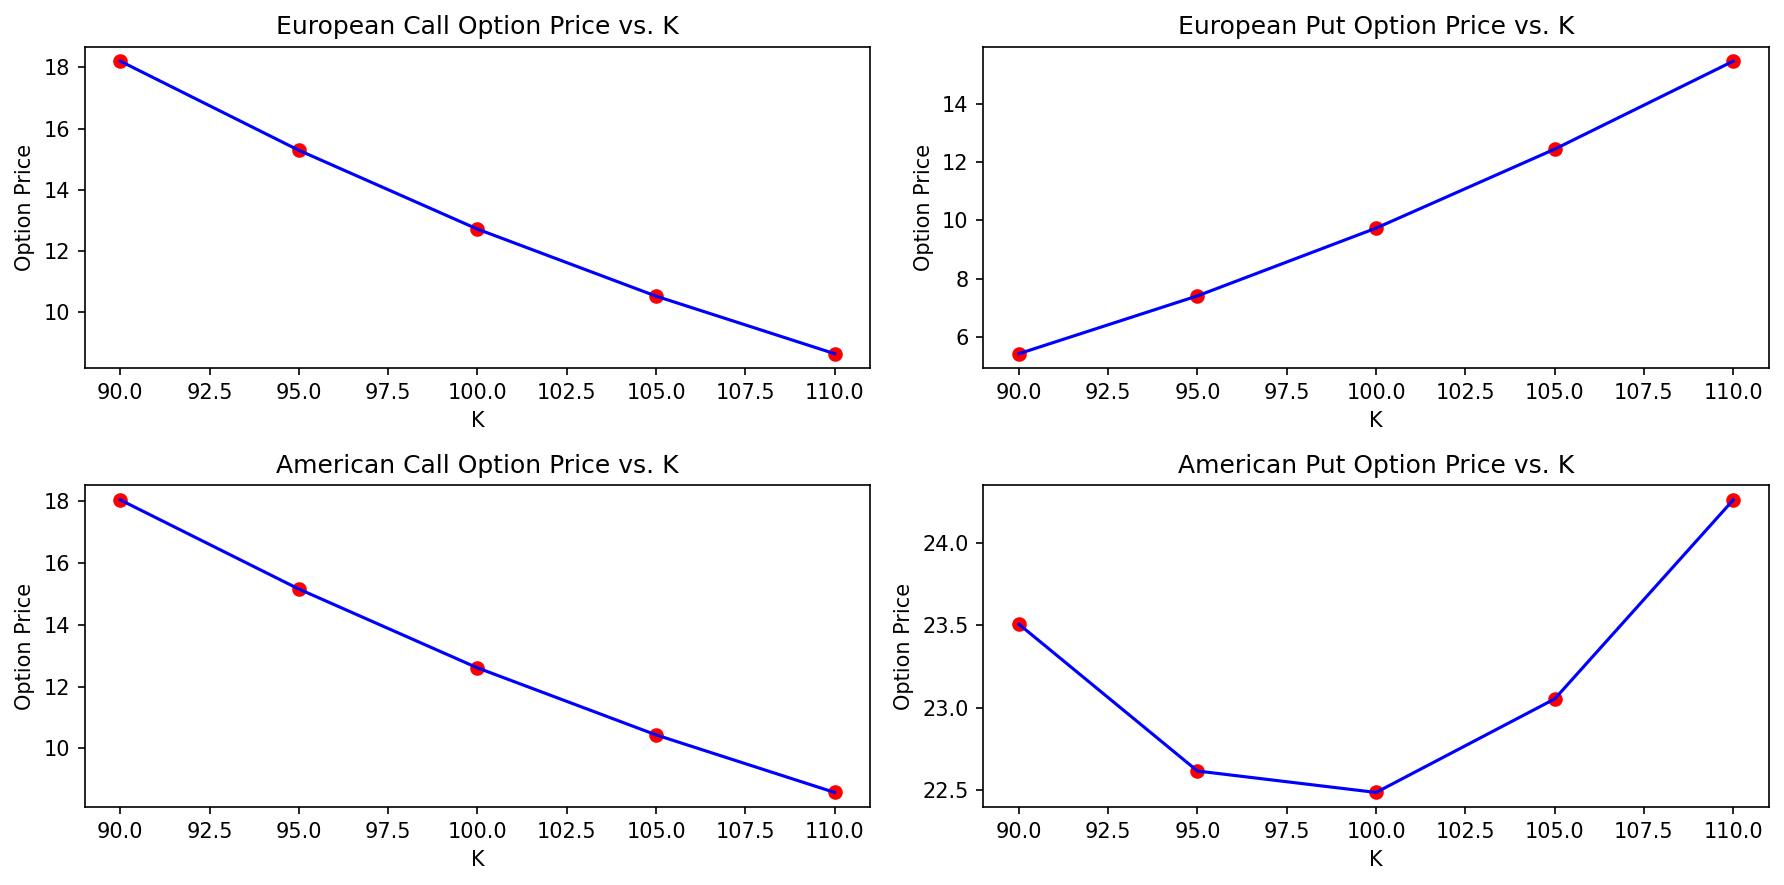

In [15]:
# 绘图：展示不同option类型的对比

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6),dpi = 150)

plt.subplot(2, 2, 1)
plt.scatter(K_list, K_european_call_option_price_list, color='r')
plt.plot(K_list, K_european_call_option_price_list,color='b')
plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('European Call Option Price vs. K')

plt.subplot(2, 2, 2)
plt.scatter(K_list, K_european_put_option_price_list, color='r')
plt.plot(K_list, K_european_put_option_price_list,color='b')
plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('European Put Option Price vs. K')

plt.subplot(2, 2, 3)
plt.scatter(K_list, K_american_call_option_price_list, color='r')
plt.plot(K_list, K_american_call_option_price_list,color='b')
plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('American Call Option Price vs. K')

plt.subplot(2, 2, 4)
plt.scatter(K_list, K_american_put_option_price_list, color='r')
plt.plot(K_list, K_american_put_option_price_list,color='b')
plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('American Put Option Price vs. K')

plt.tight_layout()  # 调整子图布局，避免重叠
plt.show()